# Resumen
En este notebook vamos a partir del dataset (airbnb-images-clean.csv)

Llevaremos a cabo la misma limpieza y seleccion de caracteristicas que hicimos en el caso de la practica del modulo de Machine Learning y que ya hemos llevado a cabo en el notebook nn_regresion_01.

Asi mismo usaremos ese mismo dataset para obtener un array con las imagenes como en el caso del notebook cnn_regresion.

En este caso vamos a usar el codigo del fichero models.py extraido del ejemplo indicado por el profesor para la realizacion de la practica.

https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

Dicho código ha sido modificado para adaptarse a nuestras necesidades.

La red cnn se alimentara con las imagenes obtenidas y la red nn con los datos(categoricos y numericos).
A su vez la salida de cada una de estas redes (las cuales obviamente no tendran la parte de regresion) alimentara a una red Neuronal tradicional (Fully Conected) que se encargara de llevar a cabo la parte de la predicción.

Como en el caso de cnn_regresion, para la generacion del array de imagenes es necesario un entorno de Colab de tipo "High Ram Runtime" el cual como ya indicamos anteriormente no siempre esta disponible. Esto ha provocado que no hayamos podido hacer todas las pruebas que nos hubiera gustado tuneando nuestro modelo mixto.

# Montar directorio Drive en colab
En primer lugar vamos a montar el directorio de Drive para poder utilizar los ficheros de carga y para guardar de manera permanente otros ficheros de interes

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Para forzar que nos pasen a un entorno de tipo "High Ram Runtime"
#a = []
#while(1):
    #a.append('1')

In [0]:
from os.path import join
ROOT = "/content/gdrive"
PROJ = "My Drive/Public/Practica_Deep_Learning_DA" 
PROJECT_PATH = join(ROOT, PROJ)


In [4]:
!ls "/content/gdrive/My Drive/Public/Practica_Deep_Learning_DA"

00-Explicacion_Practica.ipynb  descarga_imagenes.ipyn  nn_regresion_01.ipynb
cnn_regresion.ipyn	       images		       nn_regresion_02.ipynb
data			       mixed_regresion.ipynb   util


# Librerías y funciones

Lo primero es cargar las librerías y funciones necesarias.

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

#Para incluir en Colab las funciones del package utilidades creado por mi
from importlib.machinery import SourceFileLoader
import sys

missing_values_table = SourceFileLoader('missing_values_table', join(PROJECT_PATH, 'util/utilidades.py')).load_module()
change_cat_to_other = SourceFileLoader('change_cat_to_other', join(PROJECT_PATH, 'util/utilidades.py')).load_module()
create_nn = SourceFileLoader('create_nn', join(PROJECT_PATH, 'util/models.py')).load_module()
create_cnn = SourceFileLoader('create_cnn', join(PROJECT_PATH, 'util/models.py')).load_module()


sys.path.append('/content/gdrive/My\ Drive/Public/Practica_Deep_Learning_DA/util')
from missing_values_table import missing_values_table
from change_cat_to_other import change_cat_to_other
from create_nn import create_nn
from create_cnn import create_cnn


Using TensorFlow backend.


# Analisis exploratorio

## Datos de entrada

Cargamos los datos del fichero de airbnb reducido.
Este fichero contiene 14870 observaciones y 89 variables

In [0]:
full_airbnb_images = pd.read_csv(join(PROJECT_PATH,'data/airbnb-images-clean.csv'),sep=';', decimal='.')

## Outliers
Antes de nada, vamos a hacer una pequeña limpieza de los outliers de precio,

In [0]:
full_airbnb_images = full_airbnb_images[(full_airbnb_images['Price']>10) & (full_airbnb_images['Price']<200)]

## Limpieza general

Antes de llevar a cabo el split entre Trainintg y Test eliminamos las columnas que tenemos claro que no van a ser utiles para nuestro objetivo:
1. **Las que contienen URLs**: Listing Url: drop_url  
2. **Los Ids y lo relativo al Scrape realizado**: drop_id_scrape
3. **Nombres y comentarios**:drop_comments
4. **Direcciones**: A la vista de la informacion que contienen las variables de direccion podemos dropear varias de ellas por diversos motivos (sin que tengamos que dividir previamente en Train Test). Demasiado genericas: City, State, Market, Smart Location, Country Code, Country, Jurisdiction Names. Demasiado concretas: Street, Latitude, Longitude y Geolocation. Demasiado ruido o demasiados registros nulos: Neighbourhood, Host Location, Host Neighbourhood. Por ultimo, Zipcode es una variable que para representar la direccion no me parece la mas adecuada debido a que aunque es un numero, deberia ser tratado como una variable categorica. Ademas contiene bastante ruido, una cantidad no despreciable de nulos y tambien es demasiado concreta (506 valores unicos)     Por tanto y para la evaluacion del modelo deberemos barajar cual de las dos opciones que quedan es la mejor para representar la "zona" en la que se encuentra el piso ( Neighbourhood Cleansed o Neighbourhood Group Cleansed, las cuales obviamente van a estar fuertemente correladas), pero esto debera hacerse una vez separado el dataset, para que los datos de Test no influyan en la decision. (En cualquier caso sera necesario hacer un trabajo de limpieza y categorizacion con la variable elegida):drop_address
5. **Informascion relativa al Hospedador**: drop_host
6. **Nuevo campo incluido en la descarga de imagenes**: image_path

In [0]:
drop_url = np.array(['Listing Url', 'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url', 'Host URL',
                     'Host Thumbnail Url','Host Picture Url'])
full_airbnb_images.drop(drop_url, axis=1, inplace=True)

drop_id_scrape = np.array(['ID', 'Scrape ID', 'Last Scraped', 'Host ID', 'Calendar last Scraped'])
full_airbnb_images.drop(drop_id_scrape, axis=1, inplace=True)


drop_comments = np.array(['Name', 'Summary', 'Space', 'Description', 'Neighborhood Overview', 'Notes',
                     'Transit','Access', 'Interaction', 'House Rules', 'Host Name', 'Experiences Offered',
                         'Host About', 'Amenities', 'Features'])

full_airbnb_images.drop(drop_comments, axis=1, inplace=True)

drop_address = np.array(['Host Location', 'Host Neighbourhood', 'Neighbourhood', 'Street', 'Zipcode', 
    'City', 'State', 'Market', 'Smart Location','Country Code', 'Country', 'Latitude', 
                         'Longitude', 'Jurisdiction Names', 'Geolocation'])

full_airbnb_images.drop(drop_address, axis=1, inplace=True)

drop_host = np.array(['Host Since', 'Host Response Time', 'Host Response Rate', 'Host Acceptance Rate', 
    'Host Listings Count', 'Host Total Listings Count','Host Verifications', 'Calculated host listings count'])

full_airbnb_images.drop(drop_host, axis=1, inplace=True)

#Por ultimo borramos la nueva columna incluida en el proceso de descarga de imagenes image_path
full_airbnb_images.drop(['image_path'], axis=1, inplace=True)



Por ultimo eliminamos varios campos sueltos por los siguientes motivos:
* **Square Feet**: Contiene 96% observaciones null
* **Weekly Price**: Contiene 76% observaciones null
* **Monthly Price**: Contiene 76% obsevaciones null
* **Has Availability**: Contiene 99% observaciones null
* **First Review**: No creemos que aporte informacion util para el calculo del precio
* **Last Review**: No creemos que aporte informacion util para el calculo del precio
* **Calendar Updated**: No creemos que aporte informacion util para el calculo del precio
* **License**: Contiene 98% observaciones null
* **Bed Type**: Casi el 99% de las camas son del mismo tipo (Real Bed)




In [0]:
drop_varios = np.array(['Square Feet', 'Weekly Price', 'Monthly Price', 'Has Availability', 'First Review', 'Last Review',
                     'Calendar Updated','License', 'Bed Type'])

full_airbnb_images.drop(drop_varios, axis=1, inplace=True)

In [10]:
full_airbnb_images.shape

(11476, 29)

**Tras la limpieza inicial nos hemos quedado con 29 caracteristicas (y el target).**

## Generacion del array de Imagenes
En lugar de volver a recorrer todas las imagenes como en el caso de cnn_regresion vamos a usar el fichero que creamos, en ese mismo notebook, con los datos del array de imagenes

In [0]:
from numpy import load
N=full_airbnb_images.shape[0]
#Definimos primero un array con el tamaño adecuado
data = np.empty((N, 144, 216, 3), dtype=np.uint8)

dict_data = load(join(PROJECT_PATH,'data/data.npz'))
# extract the first array
data = dict_data['arr_0']

# Normalizamos los pixeles de las imagenes al rango [0,1]
data = data/255.0

In [12]:
data.shape

(11476, 144, 216, 3)

In [13]:
data[0][0][0][0]

0.0013840830449826991

## Separación Train Test

Llevaremos a cabo la separacion conjunta del dataset y del array de imagenes para que coincidan en el mismo orden

In [14]:
from sklearn.model_selection import train_test_split
(train, test, trainImagesX, testImagesX) = train_test_split(full_airbnb_images, data, test_size=0.25, random_state=55)
print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')
# Guardamos
train.to_csv('/content/gdrive/My Drive/Public/Practica_Deep_Learning_DA/data/train_clean.csv', sep=';', decimal='.', index=False)
test.to_csv('/content/gdrive/My Drive/Public/Practica_Deep_Learning_DA/data/test_clean.csv', sep=';', decimal='.', index=False)

Dimensiones del dataset de training: (8607, 29)
Dimensiones del dataset de test: (2869, 29)


**Tengamos en cuenta que a partir de ahora todo el analisis exploratorio y selección de caracteristicas se hara sobre el dataset de entrenamiento.**
**Posteriormente todas transformaciones llevadas a cabo en dicho dataset se deberan implementar en el de Test.**

## Limpieza y preprocesado de variables categoticas

Empecemos tratando las variables de vecindario (Neighbourhood Cleansed y Neighbourhood Group Cleansed)

In [0]:
print(len(train['Neighbourhood Cleansed'].unique()))
print(train['Neighbourhood Cleansed'].isna().sum())
with pd.option_context("display.max_rows", 1000):
    print(train['Neighbourhood Cleansed'].value_counts())

In [0]:
print(len(train['Neighbourhood Group Cleansed'].unique()))
print(train['Neighbourhood Group Cleansed'].isna().sum())
with pd.option_context("display.max_rows", 1000):
    print(train['Neighbourhood Group Cleansed'].value_counts())

A la vista de los datos anteriores tenemos la siguiente información:
- La variable "Neighbourhood Cleansed" contiene 390 categorias y ningun valor null.
- La variable "Neighbourhood Group Cleansed contiene 46 categorias y 526 celdas null.En lugar de imputar los nulls a la categoria "Other" lo rellenamos con el valor de la columna "Neighbourhood Cleansed"

In [0]:
train['Neighbourhood Group Cleansed'].fillna(train['Neighbourhood Cleansed'], inplace=True)

Es cierto que ahora hemos pasado de 46 categorias a 230, pero creemos que esta distribucion es mas realista que la de incluir tantos pisos en la categoria de Other.



A continuación trataremos las otras tres variables categoricas que nos quedan (Property Type, Room Type y Cancellation Policy)

In [0]:
print(train['Property Type'].value_counts())
print(train['Room Type'].value_counts())
print(train['Cancellation Policy'].value_counts())


Vamos a dejar las categorias de Property Type en "Apartment", "House", "Condominium", "Bed & Breakfast", "Loft", "Dorm", "Guesthouse", "Chalet", "Townhouse", "Hostel" y "Villa" que representan mas del 95% del total y todas las demas las incluiremos en la categoría "Other".
Para ello usaremos la funcion change_cat_to_other del pakcage utilidades

In [0]:
array_main_cat_property_type = ['Apartment', 'House', 'Condominium', 'Bed & Breakfast', 'Loft', 'Dorm', 'Guesthouse',
                               'Chalet', 'Townhouse', 'Hostel', 'Villa']
train['Property Type'] = change_cat_to_other(array_main_cat_property_type, train['Property Type'])
train['Property Type'].value_counts()

De la misma manera vamos a dejar las categorias de Cancellation Policy en "strict", "flexible" y "moderate", que representan mas del 96% del total y todas las demas las incluiremos en la categoría "Other".
Usamos nuevamente la funcion change_cat_to_other

In [20]:
array_main_cat_cancellation_policy = ['strict', 'flexible', 'moderate']
train['Cancellation Policy'] = change_cat_to_other(array_main_cat_cancellation_policy, train['Cancellation Policy'])
train['Cancellation Policy'].value_counts()

strict      3175
flexible    2781
moderate    2578
Other         73
Name: Cancellation Policy, dtype: int64

## Codificacion de las variables categoricas (Mean encoding)
Una vez reducidas las categorias de las variables categoricas, las convertiremos en numericas mediante el mecanismo de mean
encoding.
Guardamos las transformacion hechas en Train para reproducirlas en Test con un replace o un map sin volver a aplicar el mean encoding para evitar que los datos de test infulyan en el modelo.
Para aplicar le metodo Mean Encoding es conveniente que no haya NaNs en la variable Target (Price), por ello imputaremos esos valores con la media de los precios.

In [0]:
y_train_mean = np.mean(train['Price'])
train['Price'] = train['Price'].fillna(y_train_mean)

In [0]:
#Property Type
mean_encode_property_type = train.groupby('Property Type')['Price'].mean()
train.loc[:,'Property Type'] = train['Property Type'].map(mean_encode_property_type)

#Cancellation Policy 
mean_encode_cancellation_policy = train.groupby('Cancellation Policy')['Price'].mean()
train.loc[:,'Cancellation Policy'] = train['Cancellation Policy'].map(mean_encode_cancellation_policy)

#Room Type
mean_encode_room_type = train.groupby('Room Type')['Price'].mean()
train.loc[:,'Room Type'] = train['Room Type'].map(mean_encode_room_type)

#Neighbourhood Cleansed
mean_encode_neigh = train.groupby('Neighbourhood Cleansed')['Price'].mean()
train.loc[:,'Neighbourhood Cleansed'] = train['Neighbourhood Cleansed'].map(mean_encode_neigh)

#Neighbourhood Group Cleansed
mean_encode_neigh_group = train.groupby('Neighbourhood Group Cleansed')['Price'].mean()
train.loc[:,'Neighbourhood Group Cleansed'] = train['Neighbourhood Group Cleansed'].map(mean_encode_neigh_group)


In [27]:
type(mean_encode_property_type)

pandas.core.series.Series

## Correlacion de variables


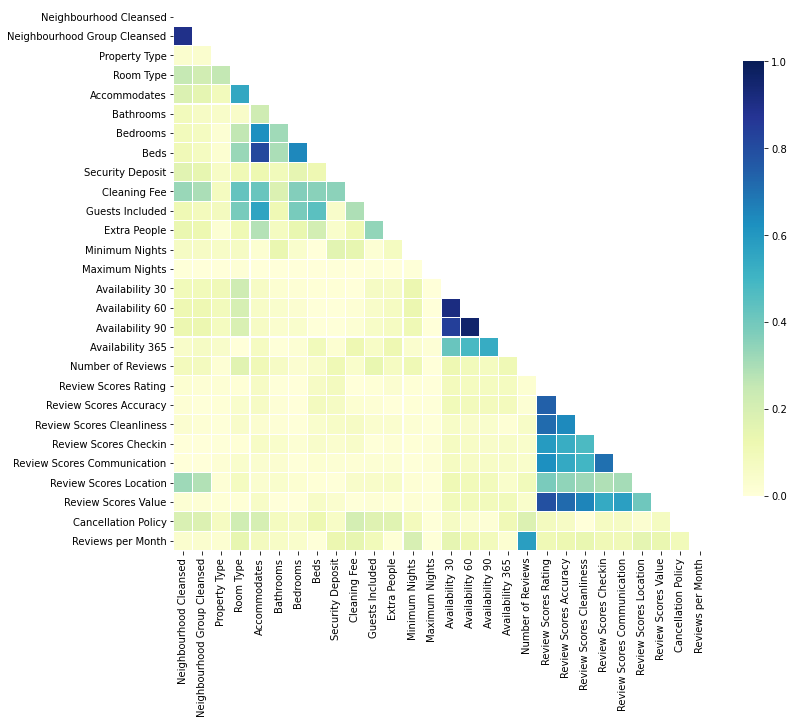

In [25]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(train.drop(['Price'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

A la vista de la grafica de correlacion y siendo un poco generosos con las variables a eliminar para simplificar el modelo, podemos deducir lo siguiente:
1. **Accommodates** tiene una fuerte correlacion con Bedrooms, Beds y moderada con Guests Included
2. **Availability 30** tiene fuerte correlacion con Availability 60 Availability 90 y moderada con Availability 365
3. **Review Scores Rating** tiene una fuerte correlacion con Review Scores Accuracy, Review Scores Cleanliness, Review Scores Checkin, Review Scores Communication, Review Scores Value y moderada con Review Scores Location.
4. **Number of Reviews** tiene fuerte  correlacion con Reviews per Month
5. **Neighbourhood Cleansed y Neighbourhood Group Cleansed** muestran una fuerte correlacion, pero de momento dejamos las dos para analizar mediante el filtrado de caracterisdtcas cual de las dos influye mas en la regresion que tenemos que plantear.

In [0]:
#Vamos a eliminar todas estas variables del dataset de entrenamiento
drop_corr = ['Bedrooms', 'Beds', 'Guests Included', 'Availability 60', 'Availability 90', 'Availability 365',
             'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication',
             'Review Scores Value', 'Review Scores Location', 'Reviews per Month']
train.drop(drop_corr, axis=1, inplace=True)
train.shape

## Tratamiento de NaNs (Imputacion de nulos)

Ningun modelo de Machine o Deep Learning funcionan adecuadamente sin un tratamiento previo de los NaNs de sus registros.

Por tanto debemos analizar que variables tienen valores NaN y llevemos a cabo el proceso de imputacion

Para hacerlo una opcion seria aplicar los siguientes comandos a todas las variables que quedan:
```
print(len(train['campo'].unique()))
print(train['campo'].isna().sum())
print(train['campo'].value_counts())

```

Afortunadamente contamos con la funion missing_values_table que nos permite visualizar con un unico comando los nulos que aparecen en los distintos campos del dataframe

In [0]:
missing_values_table(train)

Haciendo esto vemos que los unicos campos que contienen NaNs son:
- Bathroom (25) Imputamos la media
- Security Deposit (5015). Es mas de la mitad de los regitros por lo que lo eliminamos
- Cleaning Fee (3490). Imputamnos un cero. asumismos que quien no tiene ese dato es porque no hay gastos de limpieza.
- Review Scores Rating (1768). Imputamos la media. **En su momento consideramos que el no tener este campo relleno no era buena señal por que probamos a imputar el minimo, en lugar de la media, pero el modelo predecia peor, por lo que desestimamos nuestra hipotesis y volvimos a la media**.

In [0]:
mean_bathroom = np.mean(train['Bathrooms'])
mean_review = np.mean(train['Review Scores Rating'])
min_review = np.min(train['Review Scores Rating'])
train['Bathrooms'] = train['Bathrooms'].fillna(mean_bathroom)
train['Cleaning Fee'] = train['Cleaning Fee'].fillna(0)
train['Review Scores Rating'] = train['Review Scores Rating'].fillna(mean_review)

In [0]:
train.drop('Security Deposit', axis=1, inplace=True)

## Separacion y tratamiento de la variable dependiente (variable objetivo o target)
Separemos el dataset train entre la varible dependiente (y_train) y el resto de variables independientes (X_train)


In [0]:
y_train = train['Price']
X_train= train.drop(['Price'], axis=1)


In [0]:
X_train.shape

In [0]:
y_train.describe()

In [0]:
print(len(y_train.unique()))
print(y_train.isna().sum())
print(y_train.value_counts())
print(np.mean(y_train)) 

## Filtrado para regresion
Con las 14 variables que me quedan en X_train aplico los metodos de fitrado **f_regresion** y **mutual_info_regresion**

In [0]:
from sklearn.feature_selection import f_regression, mutual_info_regression
f_test, _ = f_regression(X_train, y_train)
f_test /= np.max(f_test)
mi = mutual_info_regression(X_train, y_train)
mi /= np.max(mi)

Mostremos esta informacion en forma de grafica

In [0]:
featureNames = list(X_train.columns)

plt.figure(figsize=(30, 10))

plt.subplot(1,2,1)
plt.bar(range(X_train.shape[1]),f_test,  align="center")
plt.xticks(range(X_train.shape[1]),featureNames, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-test$ score')


plt.subplot(1,2,2)
plt.bar(range(X_train.shape[1]),mi,  align="center")
plt.xticks(range(X_train.shape[1]),featureNames, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

A la vista de las graficas y de los valores de f_test y mi las variables que mas estan impactando en la variable objetivo son:
- Neighbourhood Cleansed (quitamos la grupal pues como ya habiamos visto esta fuertemente correlada con esta)
- Room Type
- Accommodates
- Bathrooms
- Cleaning Fee
- Extra People
- Minimum Nigths
- Availability 30
- cancelation Policy
- Review Scores Rating

Como era de esperar el barrio, el tipo de habitacion y las personas que pueden ocupar la casa son los parametros que mas afectan al precio de la casa.

Por tanto seran estas las variables que usare para testear mis modelos, elimando el resto del dataset de training

In [0]:
drop_filtrado = ['Neighbourhood Group Cleansed', 'Property Type','Maximum Nights', 'Number of Reviews']
X_train.drop(drop_filtrado, axis=1, inplace=True)

Por ultimo cambiare el nombre de la variable "Neighbourhood Group Cleansed" por "Barrio" para que sea mas manejable

In [0]:
X_train.rename(columns={'Neighbourhood Cleansed':'Barrio'}, inplace=True)

In [0]:
X_train.describe()

## Standarizacion o Escalado (mejor que llamarlo Normalizacion, ya que este termino se refiere tambien a conceptos distintos) 
Por ultimo llevamos a cabo la normalizacion. Usaremos varias opciones para ver cual es la que mejor se adapta a nuestro modelo:
*   StandarEscaler
*   MinMax


Recordemos que para test deberemos usar el scaler obtenido en train


In [0]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

#StandardScaler
standardScalerX = preprocessing.StandardScaler().fit(X_train)
XtrainStdScaled = standardScalerX.transform(X_train)

standardScalerY = preprocessing.StandardScaler().fit(np.array(y_train).reshape(-1, 1))
YtrainStdScaled = standardScalerY.transform(np.array(y_train).reshape(-1, 1))

#MinMax
cs = MinMaxScaler()
XtrainMmScaled = cs.fit_transform(X_train)

maxPrice = train["Price"].max()
YtrainMmScaled = np.array(y_train).reshape(-1, 1)/maxPrice


**Y hasta aqui el analisis exploratorio y la limpieza del dataset, empezamos con las pruebas de los modelos**

## Preparacion datos Test

Antes de iniciar la evaluacion de modelos, vamos a dejar preparado el **dataset de Test** con las mismas transformaciones que hemos llevado a cabo sobre el de Train.
Abajo indicamos el listado de dichas transformaciones para no olvidarnos de ninguna:
- Lo primero es el dropeo de las variables que no van a participar en el modelo (correlacion y filtrado): drop_corr y drop_filtrado.
- Drop de "Security Deposit"
- Tratamiento de las variables categoricas que influyen en el modelo (filtrado de categorias y Encoder): mean_encode_room_type, mean_encode_neigh y mean_encode_cancellation_policy
- Imputacion  de NaNs: Price, Bathroom y Cleaning Fee


### Analizamos y limpiamos el dataset de test

In [0]:
test = pd.read_csv('/content/gdrive/My Drive/Public/Practica_Deep_Learning_DA/data/test_clean.csv',sep=';', decimal='.')
test.shape
#test.info()

In [0]:
missing_values_table(test)

In [0]:
#Dropeamos
test.drop(drop_corr, axis=1, inplace=True)
test.drop(drop_filtrado, axis=1, inplace=True)

#Eliminamos tambien la variable Security Deposit 
test.drop('Security Deposit', axis=1, inplace=True)

#imputamos los valores NaNs del target con la media del train (y_train_mean)
media_target_test = np.mean(test['Price'])
test['Price'] = test['Price'].fillna(y_train_mean)

#Imputamos los NaNs de la misma manera que se hace en Train
test['Bathrooms'] = test['Bathrooms'].fillna(mean_bathroom)
test['Cleaning Fee'] = test['Cleaning Fee'].fillna(0)
test['Review Scores Rating'] = test['Review Scores Rating'].fillna(mean_review)


#Aplicamos el Mean Encoder a "Room Type", "Neighbourhood Cleansed" y "Cancellation Policy"  el obtenido en train, si aparece alguna categoria nueva en test
#lo trataremos a posteriori
#mean_encode_room_type_test = test.groupby('Room Type')['Price'].mean()
#mean_encode_neigh_test = test.groupby('Neighbourhood Cleansed')['Price'].mean()
#mean_encode_cancellation_policy_test = test.groupby('Cancellation Policy')['Price'].mean()
test.loc[:,'Room Type'] = test['Room Type'].map(mean_encode_room_type)
test.loc[:,'Neighbourhood Cleansed'] = test['Neighbourhood Cleansed'].map(mean_encode_neigh)
test.loc[:,'Cancellation Policy'] = test['Cancellation Policy'].map(mean_encode_cancellation_policy)


#Por ultimo cambiamos el nombre de la variable a Barrio
test.rename(columns={'Neighbourhood Cleansed':'Barrio'}, inplace=True)


In [0]:
missing_values_table(test)

Como quedan valores nulos en Barrio y Cancellation Policy debido a aplicar sobre ellas el Mean Encoding de train, lo rellenaremos con la media de las medias obtenidas para esas categoria

In [0]:
mean_mean_encode_neigh = np.mean(mean_encode_neigh)
mean_mean_encode_cancellation_policy = np.mean(mean_encode_cancellation_policy)
test['Barrio'].fillna(mean_mean_encode_neigh, inplace=True)
test['Cancellation Policy'].fillna(mean_mean_encode_cancellation_policy, inplace=True)


### Separamos la variable objetivo del tets

In [0]:
y_test = test['Price']
X_test= test.drop(['Price'], axis=1)

Normalizamos los datos de Test usando las normalizaciones de Train

In [0]:
#StandardScaler
XtestStdScaled = standardScalerX.transform(X_test)
YtestStdScaled = standardScalerY.transform(np.array(y_test).reshape(-1, 1))

#MinMax
cs = MinMaxScaler()
XtestMmScaled = cs.fit_transform(X_test)

YtestMmScaled = np.array(y_test).reshape(-1, 1)/maxPrice



In [0]:
# Normalizamos los precios de las casas a [0,1] usando el maximo de los precios del conjunto de train
maxPrice = X_train["Price"].max()
trainY = X_train["Price"] / maxPrice
testY = X_test["Price"] / maxPrice

In [0]:
X_test.shape[1]

# Mixed Input Net


In [0]:
# Llevamos a cabo los import necesarios
from keras.layers.core import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import concatenate

# Creamos las redes nn y cnn
nn = create_nn(X_train.shape[1], regress=False)
cnn = create_cnn(216, 144, 3, regress=False)

# Concatenamos la salida de cnn y nn que se convertira en la entrada de nuestro conjunto final de capas de prediccion
combinedInput = concatenate([nn.output, cnn.output])

# La capa final "Fully Connected" estara formada por dos capas densas, la ultima sera la que llevara a cabo la prediccion.
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

# Nuestro modelo final aceptara datos categoricos/numericos en la red tradicional (nn)
# e imagenes en la red convolucional (cnn), generando un valor escalar que 
#representara la prediccion del valor de la casa 
model = Model(inputs=[nn.input, cnn.input], outputs=x)

# Compilamos el modelo usando "mean_absolute_percentage_error" como funcion de perdida
opt = Adam(lr=0.001, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

# Entrenamos el modelo
#Usamos los datos categoricos/numericos sin normalizar porque como hemos podido comprobar en nn_regresion_02 dan mejor resultado que los normalizados
n_epochs = 100
print("[INFO] training model...")
history_callback = model.fit(
	[XtrainStdScaled, trainImagesX], YtrainStdScaled,
	validation_data=([XtestStdScaled, testImagesX], YtestStdScaled),
	epochs=n_epochs, batch_size=64)


### Curva de perdidas

In [0]:
# veamos nuestra curva de pérdidas
plt.plot(np.arange(0, n_epochs), history_callback.history["loss"])
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")

A la vista de estos datos observamos una curva con muchas mas irregularidades y que tarda mas en converger.


### Bondad del modelo

In [0]:
# Obtenemos la prediccion de nuestro modelo para los datos de Test
preds = model.predict([X_test, testImagesX])
 

# Calulamos la diferencia entre los precios predichos y los reales
# A continuacion calcularemos la diferencia porcentual y la diferecia absouta en porcentaje
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)
 

#Calculamos la media y la desviacion estandar
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
 
# Mostramos las estadisticas de nuestro modelo.
print("Precio medio de las pisos: {:.2f}€, Desviacion standar: {:.2f}€".format(
    full_airbnb_images["Price"].mean(), full_airbnb_images["Price"].std()))
print("Modelo --> mean: {:.2f}%, std: {:.2f}%".format(mean, std))

In [0]:
history_callback.history["loss"]